<a href="https://colab.research.google.com/github/victory06/TFG/blob/master/Second.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
"""
Lee las bases de datos y comprueba si hay datos perdidos:
    - path_data: indica la ruta del archivo con la base de datos
    - path_names: indica la ruta del archivo con los nombres de las columnas (SNPs)
    - path_control: ruta con los datos de control (individuos sanos)
    - path_col_control: ruta con los nombres de los SNPs de los datos de control
"""
import pandas as pd
import numpy as np
import collections as col
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

def readData(path_data, path_names, path_control, path_col_control):
  """ Leemos los datos
  --------------------------------------------------------------------------"""
  data = pd.read_csv(path_data, sep=" ", header=None)
  names_col = pd.read_csv(path_names, sep=",", header=None)
  control = pd.read_csv(path_control, sep=" ", header=None)
  names_ctrl = pd.read_csv(path_col_control, sep=",", header=None)

  """ Primero leo los nombres de los datos de las columnas de datos
  --------------------------------------------------------------------------"""
  # Tomamos los nombres de los snpis para nombrar las columnas
  names_c = names_col.to_numpy()[:,:].astype('U13')
  # En la columna 0 estan los nombres de los SNIPS
  names_column = names_c[:,0]

  """ Ahora buscamos las columnas en común entre los datos y los de control
  --------------------------------------------------------------------------"""
  names_ctrl_aux = names_ctrl.to_numpy()[:,:].astype('U13')
  names_control = names_ctrl_aux[:,0]
  delete = []
  for value in names_column:
    pos = np.where(names_control == value)
    if pos[0].size==0:
      delete.append(value)
  #Encontramos las dos posiciones a borrar que serán 4 en la base de datos
  borrar1 = np.where(names_column == delete[0])
  borrar2 = np.where(names_column == delete[1])
  names_column=np.delete(names_column, [borrar1[0][0],borrar2[0][0]])
  #Borramos las 4 posiciones desde la mas alta para que no afecte a las posiciones
  #más bajas a borrar
  #Se borra la posicion de la bd por 2 porque se repiten los SNPs, mas 7 por las 7
  #columnas iniciales y más 1 o 0 para borrar la pareja
  data.drop(data.columns[borrar2[0][0]*2+7+1], axis=1, inplace=True)
  data.drop(data.columns[borrar2[0][0]*2+7], axis=1, inplace=True)
  data.drop(data.columns[borrar1[0][0]*2+7+1], axis=1, inplace=True)
  data.drop(data.columns[borrar1[0][0]*2+7], axis=1, inplace=True)
  print("Posiciones borradas: ", delete)
  #Renombro las columnas para que el concat se haga bien
  data.columns=list(control.columns.values)
  """ Tratamos los nombres de los datos de las columnas con el formato correcto
  --------------------------------------------------------------------------"""
  names_column = np.repeat(names_column,2)
  names_column = np.insert(names_column, 0, "Gender", axis=0)

  """ Trato ahora con data
  --------------------------------------------------------------------------"""
  # Elimino los hijos de data
  row_elim=[]
  for i in range(0, data.shape[0]):
    if(data[2][i] != '0'):
      row_elim.append(i)
    else:
      data[5][i]='2'
  data=data.drop(row_elim)

  """ Junto con los datos de control
  --------------------------------------------------------------------------"""
  frames = [data,control]
  result = pd.concat(frames)
  """ Borro columnas de los datos
  --------------------------------------------------------------------------"""
  # Predecimos el affection status
  y = result.iloc[:,5]
  # Borramos la columna que queremos predecir
  result.drop(result.columns[5], axis=1, inplace=True)
  # Como nombre de las columnas vamos a establecer el ID del inivididuo
  names_row = result.iloc[:,1]
  # Borramos los ID
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[1], axis=1, inplace=True)

  """ Establezco los nombres del dataframe
  --------------------------------------------------------------------------"""
  x_df = pd.DataFrame(result.to_numpy()[:,:].astype('U13'),index=names_row, columns = names_column)
  y_df = y.values.flatten()

  """ Comprobamos que no haya datos perdidos
  --------------------------------------------------------------------------"""
  if x_df.isnull().values.any():
    print("Hay datos perdidos")
  else:
    print("No hay datos perdidos")

  return x_df, y_df

def metricas(y_real, y_pred, etiquetas):
  clasf = classification_report(y_real, y_pred, target_names=etiquetas)
  print(clasf)
  return clasf

def explorarBD(x_train, x_test, x, y, y_train, y_test):
  print("Número de instancias y número de variables:", x.shape)
  print("Valores de clase:",pd.unique(y))
  print("Número de instancias para cada clase: ",col.Counter(y))
  print("Número de instancias para cada clase test: ",col.Counter(y_test))
  print("Número de instancias para cada clase train: ",col.Counter(y_train))
  print("Numero de instancias en entrenamiento: {}; y test: {}".format(len(x_train),len(x_test)))

def f_importances(coef, names):
  imp = coef
  imp,names = zip(*sorted(zip(imp,names)))
  plt.barh(range(len(names)), imp, align='center')
  plt.yticks(range(len(names)), names)
  plt.show()


# Primeros datos de control

In [77]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
x, y= readData('/content/drive/MyDrive/TFG/Autism/AutismDuoChrom26.iou','/content/drive/MyDrive/TFG/Autism/Human1M-Duov3_B_PosSortedChrom26.cols','/content/drive/MyDrive/TFG/NBS/WTCCC2_NBSChrom26.iou',
               '/content/drive/MyDrive/TFG/MS/WTCCC2_MS_Human670-QuadCustom_v1_APosSortedChrom26.cols')
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.25,random_state=1)
explorarBD(x_train, x_test, x, y , y_train, y_test)
x[4417:]

Posiciones borradas:  ['mitoc10874t', 'mitog10590a']
No hay datos perdidos
Número de instancias y número de variables: (4427, 273)
Valores de clase: [2 0]
Número de instancias para cada clase:  Counter({0: 2699, 2: 1728})
Número de instancias para cada clase test:  Counter({0: 694, 2: 413})
Número de instancias para cada clase train:  Counter({0: 2005, 2: 1315})
Numero de instancias en entrenamiento: 3320; y test: 1107


,Gender,mitoa10045g,mitoa10045g,mitoa10551g,mitoa10551g,mitoa11252g,mitoa11252g,mitoa11468g,mitoa11468g,mitoa12309g,mitoa12309g,mitoa13106g,mitoa13106g,mitoa13264g,mitoa13264g,mitoa13781g,mitoa13781g,mitoa14234g,mitoa14234g,mitoa14583g,mitoa14583g,mitoa15245g,mitoa15245g,mitoa15302g,mitoa15302g,mitoa15759g,mitoa15759g,mitoa15925g,mitoa15925g,mitoa16163g,mitoa16163g,mitoa16164g,mitoa16164g,mitoa1738g,mitoa1738g,mitoa3349g,mitoa3349g,mitoa3481g,mitoa3481g,mitoa3721g,...,mitot3198c,mitot3198c,mitot3395c,mitot3395c,mitot4337c,mitot4337c,mitot4562c,mitot4562c,mitot479c,mitot479c,mitot491c,mitot491c,mitot4978c,mitot4978c,mitot5005c,mitot5005c,mitot5443c,mitot5443c,mitot5496c,mitot5496c,mitot6153c,mitot6153c,mitot6222c,mitot6222c,mitot6681c,mitot6681c,mitot6777c,mitot6777c,mitot7176c,mitot7176c,mitot8278c,mitot8278c,mitot9699c,mitot9699c,mitot9717c,mitot9717c,mitot9900c,mitot9900c,mitot9951c,mitot9951c
1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BLOOD292382,2,16158,1235,22090,3036,21290,3114,23402,3280,18957,2758,8825,1883,24397,3374,5890,1334,12171,1730,15253,1814,14577,2786,7889,27210,26206,3587,16297,3960,17815,5101,20815,2467,18078,2619,22347,3955,18081,2681,22678,...,27243,2766,23881,4206,31302,5166,25430,6792,12436,2241,11457,1312,21134,4714,17825,3434,15692,2525,24920,3233,11031,3435,16201,6136,26425,3532,31260,3107,18607,2624,23775,8877,15029,3501,19272,4381,17039,2297,14205,1661
BLOOD293997,2,30963,1471,6336,22600,33477,3080,4884,26965,7573,23792,13867,1765,37482,3598,18474,2054,18770,1570,0,0,22577,2842,15332,27258,38515,3312,29387,3414,29393,6308,28767,2241,27469,2433,36321,4847,5018,21967,38059,...,43858,3099,36321,3681,43355,5506,43112,6192,31051,3961,23729,1857,33021,4844,26382,3520,23064,2272,44467,3556,13827,2299,25632,4417,38073,3591,48968,3176,26800,2389,38628,8459,4804,17064,25611,4181,31390,3558,19621,1225
WS577911,2,21043,903,29912,3010,25044,2028,31417,2424,24821,2473,12847,1316,27334,2827,10098,1067,14873,1219,18179,1004,21209,2421,11322,20725,31162,2922,26315,2612,21187,5122,25511,1775,23495,1997,26435,4587,24907,2249,28036,...,33254,2659,27608,3462,34723,5918,34653,5985,3084,12581,7160,672,31064,3679,20991,2676,17331,1358,32150,2402,15313,2440,22081,5855,32253,2733,42584,3012,23018,1667,27626,7535,17857,3826,23145,3564,26217,2686,16877,1067
WS578376,2,20424,1096,29376,3828,3769,21616,31479,2709,25029,2987,12906,1720,29742,2666,12120,1433,15861,1417,17454,1344,19829,2637,12857,22011,33457,3638,24895,2706,13764,3082,15150,1373,21849,2055,29025,4906,23890,2263,31478,...,40912,2754,28629,2922,36713,6420,36118,6531,20247,2310,2784,12888,27767,4181,20819,2940,15934,1846,33296,2888,12332,2407,22549,5115,29188,3044,39640,2995,22213,1955,23376,5715,15323,4466,23785,3810,25363,2615,16008,1091
WS574632,1,29226,1006,42017,2983,38135,2429,45182,2640,35891,2419,15268,1391,40718,2634,2459,13978,22821,1488,20050,1435,27020,2558,15298,37083,45439,3138,3667,28250,30468,3895,30494,1511,27232,1577,43320,3955,33288,2362,44037,...,50924,2601,43834,3476,54942,4667,42034,5517,28363,2397,18628,973,43578,4571,33463,2932,23985,1803,48149,2900,19694,2884,32746,5810,46457,2823,60872,2443,29814,1677,35479,8385,23624,3115,35016,4163,37421,2603,24581,1186
WS574661,1,27022,1073,30260,2407,27356,1867,34221,2146,27750,2242,13598,1257,32709,2232,13355,1446,14807,948,13133,899,20814,1975,11669,26314,40989,2903,19959,1616,22092,2798,33775,1746,23722,1526,30555,2628,22782,1618,27016,...,41879,2035,30013,2232,46190,3855,33538,4520,29180,2495,13492,771,25610,2556,34051,2727,20180,1692,43542,2456,13582,2231,21478,3606,29146,1653,52772,2414,26437,1666,31913,7025,17616,2362,30591,3609,24351,1939,18743,962
WTCCCT510912,2,7836,775,2184,18282,17250,1714,1157,9054,2577,23435,6836,1004,18139,2084,3067,919,6149,858,2819,885,9239,1273,6935,33690,19150,2443,16780,2306,14614,1851,11893,1040,14230,1546,18136,2406,1824,22413,16726,...,12493,1104,17087,2422,27456,4088,16146,4261,10076,1438,5477,811,17696,3295,16054,1858,4454,

### K Vecinos Más Cercanos


In [78]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier() 
knn.fit(x_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [79]:
y_pred = knn.predict(x_test) # predicción de cada etiqueta 

# imprimimos la etiqueta calculada para los 20 primeros datos de X_test
print(y_pred[:20]) 
print(y_test[:20])

[2 2 2 0 2 0 0 0 2 0 0 0 2 0 2 0 2 0 2 0]
[2 2 2 0 2 0 0 0 2 0 0 0 0 0 2 0 2 2 2 0]


In [80]:
from sklearn.metrics import accuracy_score

acc_score = accuracy_score(y_test, y_pred)
print(acc_score)

0.7877145438121048


In [81]:
import numpy as np
from sklearn.model_selection import cross_val_score

scores = cross_val_score(knn, x, y) #por defecto 5 particiones

print(scores) #los valores individuales de cada partición
print(np.mean(scores)) #la media de acierto global

[0.78103837 0.79458239 0.81355932 0.76384181 0.7740113 ]
0.7854066393745776


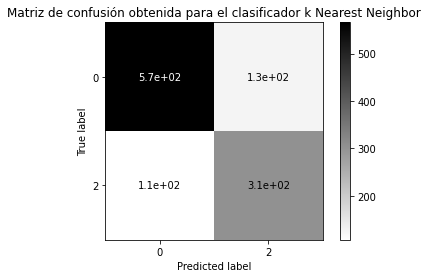

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       694
           2       0.71      0.74      0.72       413

    accuracy                           0.79      1107
   macro avg       0.77      0.78      0.78      1107
weighted avg       0.79      0.79      0.79      1107

La medida F1 para el clasificador KNeighborsClassifier es 0.7226


In [82]:
from sklearn import metrics
import matplotlib.pyplot as plt

#el parámetro cmap utilizar un mapa de color en azules para ser cómodo a la vista
metrics.plot_confusion_matrix(knn, x_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador k Nearest Neighbor")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(knn.__class__.__name__,f1))

### Regresión Logística

Coef. independiente: [2.63711438e-07]
Coef. por variable: [[ 3.92171480e-07  1.76480342e-04  1.07588565e-04 -3.13003515e-04
  -3.56699119e-05 -7.43093648e-06 -1.18562009e-04  1.42945037e-04
   6.83295075e-05  3.79772986e-05  3.78156740e-05  2.74449031e-05
  -2.73832478e-05 -3.07014727e-04 -1.55877825e-04 -1.12515053e-05
  -1.75104560e-04  2.93005412e-04 -4.50963540e-05  4.80537277e-04
  -8.29419223e-05  2.28222638e-04  2.67747035e-04  8.54842341e-05
   1.09153125e-04  6.74878112e-05  9.69159140e-05 -2.38366305e-04
  -3.50049146e-04 -9.19283044e-05 -2.21758577e-04  9.90819204e-05
  -1.30094493e-04  2.22212570e-06 -1.03152973e-04  5.42222135e-05
   4.13720310e-05  1.54585965e-04  4.09323667e-05  1.21478310e-04
  -2.30218530e-04  5.72031223e-05 -1.24457232e-04  4.75295365e-05
   1.18352790e-04  3.88538991e-06  5.76163374e-05 -1.38898862e-04
  -6.33315836e-05  8.50655864e-05  4.19678615e-05 -3.03489075e-04
  -1.59317238e-04 -8.31480178e-05  8.32040964e-06  4.53760366e-05
   1.88485343e-04 

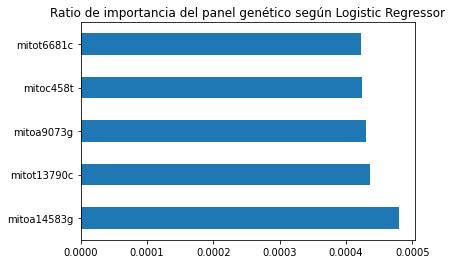


Valores de predicción originales (10 primeros):
[0 2 2 0 2 0 0 0 2 0]

Acierto de Logistic Regression en la partición de test: 0.912375790424571


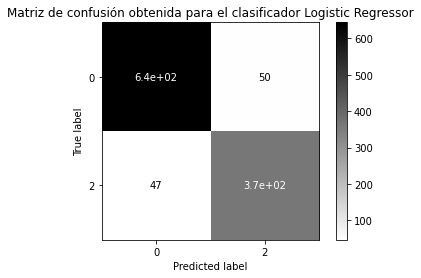

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       694
           2       0.88      0.89      0.88       413

    accuracy                           0.91      1107
   macro avg       0.91      0.91      0.91      1107
weighted avg       0.91      0.91      0.91      1107

La medida F1 para el clasificador LogisticRegression es 0.8830


In [83]:
from sklearn import linear_model
from sklearn.preprocessing import normalize
lrm = linear_model.LogisticRegression()

lrm.fit(x_train, y_train)
print("Coef. independiente:",lrm.intercept_)
print("Coef. por variable:",lrm.coef_)
print()

importancia = np.abs(lrm.coef_[0]) #transformamos a una lista uni-dimensional
importancia_norm = normalize(importancia[:,np.newaxis], axis=0).ravel()
#Se representan las 5 más importantes según valor absoluto
(pd.Series(importancia, index=x_train.columns).nlargest(5).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Logistic Regressor")
plt.show()
print()

y_pred = lrm.predict(x_test)

print("Valores de predicción originales (10 primeros):")
print(y_pred[:10])
print()

acc_score = accuracy_score(y_test, y_pred)
print("Acierto de Logistic Regression en la partición de test:", acc_score)

metrics.plot_confusion_matrix(lrm, x_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Logistic Regressor")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(lrm.__class__.__name__,f1))

### Árbol de decisión

In [84]:
from sklearn import tree

dt = tree.DecisionTreeClassifier()
dt.fit(x_train, y_train)

y_pred = dt.predict(x_test)

acc_score = accuracy_score(y_test, y_pred)
print("Acierto de DT en la partición de test:", acc_score)

Acierto de DT en la partición de test: 0.8635953026196929


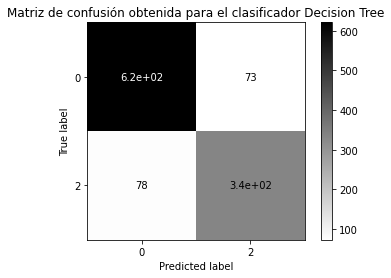

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       694
           2       0.82      0.81      0.82       413

    accuracy                           0.86      1107
   macro avg       0.85      0.85      0.85      1107
weighted avg       0.86      0.86      0.86      1107

La medida F1 para el clasificador DecisionTreeClassifier es 0.8161


In [85]:
metrics.plot_confusion_matrix(dt, x_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Decision Tree")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(dt.__class__.__name__,f1))

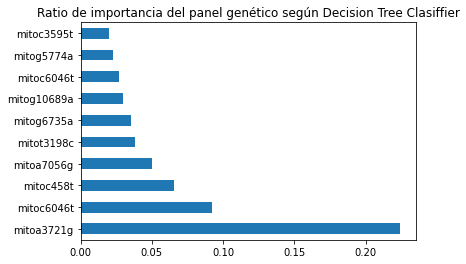

In [86]:
#En primer lugar, se capturan los valores del ranking de importancia
importancia = dt.feature_importances_
#Se representan las 5 más importantes
(pd.Series(importancia, index=x_train.columns).nlargest(10).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Decision Tree Clasiffier")
plt.show()

### Máquinas de soporte vectorial

In [87]:
from sklearn import svm
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

clf = svm.SVC(C=100.0, break_ties=False, cache_size=200,
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)
acc = accuracy_score(y_test,y_pred)
print("Acierto SVM ",acc)

Acierto SVM  0.957542908762421


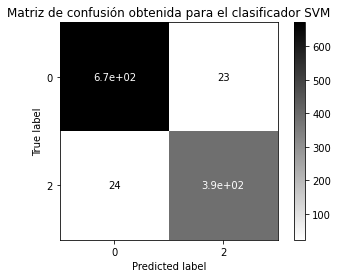

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       694
           2       0.94      0.94      0.94       413

    accuracy                           0.96      1107
   macro avg       0.95      0.95      0.95      1107
weighted avg       0.96      0.96      0.96      1107

La medida F1 para el clasificador SVC es 0.9662


In [88]:
metrics.plot_confusion_matrix(clf, x_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador SVM")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label=0)
print("La medida F1 para el clasificador %s es %.4f"%(clf.__class__.__name__,f1))

### *Gradient Boosting*

In [89]:
from sklearn.ensemble import GradientBoostingClassifier
GBoost = GradientBoostingClassifier(n_estimators=200, learning_rate=0.9,
                                 max_depth=2, random_state=0).fit(x_train, y_train)
GBoost.score(x_test, y_test)

0.971093044263776

El porcentaje de acierto obtenido es 97.10930442637759


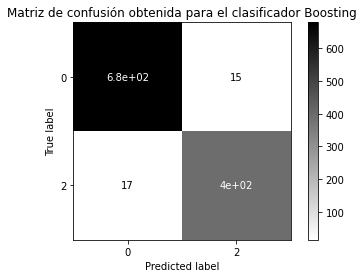

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       694
           2       0.96      0.96      0.96       413

    accuracy                           0.97      1107
   macro avg       0.97      0.97      0.97      1107
weighted avg       0.97      0.97      0.97      1107

La medida F1 para el clasificador GradientBoostingClassifier es 0.9612


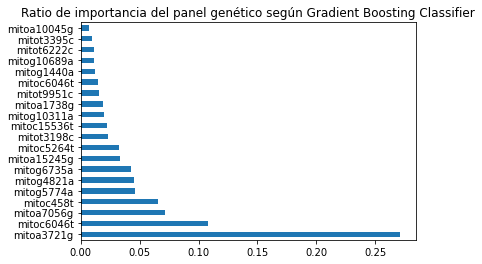

In [90]:
y_pred = GBoost.predict(x_test)
acc = accuracy_score(y_test,y_pred)
print("El porcentaje de acierto obtenido es",acc*100)

metrics.plot_confusion_matrix(GBoost, x_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Boosting")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(GBoost.__class__.__name__,f1))

#En primer lugar, se capturan los valores del ranking de importancia
importancia = GBoost.feature_importances_
#Se representan las 5 más importantes
(pd.Series(importancia, index=x_train.columns).nlargest(20).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Gradient Boosting Classifier")
plt.show()

### *GridSearch CV*

In [91]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
preproc=[("var", VarianceThreshold(0.01)),
        ("standardize", StandardScaler()),
        ("poly", PolynomialFeatures(2))]

pipe=Pipeline([('lr', LogisticRegression())])

In [92]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

params_grid=[
          {"lr":[LogisticRegression(penalty='l1',max_iter=500)],
                "lr__C":np.logspace(-2,2,5),
                "lr__solver":['lbfgs']},
          {"lr": [RandomForestClassifier(random_state = 1, n_jobs = -1, criterion = 'entropy')],
          "lr__n_estimators": [100, 250],
          "lr__max_depth": [9, 10]},
          {"lr": [SVC(class_weight='balanced', gamma='scale', degree=2)],
               "lr__C":np.logspace(-2,2,5),
               "lr__kernel": ['rbf', 'poly']}
            
]
best_lr=GridSearchCV(pipe,params_grid, scoring='accuracy', cv=5, n_jobs=-1)
best_lr.fit(x_train,y_train)
print("Parámetros del mejor clasificador:\n{}".format(best_lr.best_params_))
print("Accuracy en CV: {:0.3f}%".format(100.0 * best_lr.best_score_))
print("Accuracy en training: {:0.3f}%".format(
        100.0 * best_lr.score(x_train, y_train)))
print("Accuracy en test: {:0.3f}%".format(
        100.0 * best_lr.score(x_test, y_test)))

Parámetros del mejor clasificador:
{'lr': SVC(C=100.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False), 'lr__C': 100.0, 'lr__kernel': 'rbf'}
Accuracy en CV: 95.241%
Accuracy en training: 99.518%
Accuracy en test: 95.664%


El porcentaje de acierto obtenido es 95.6639566395664


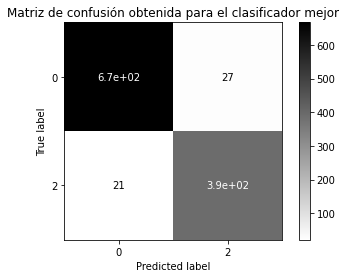

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       694
           2       0.94      0.95      0.94       413

    accuracy                           0.96      1107
   macro avg       0.95      0.96      0.95      1107
weighted avg       0.96      0.96      0.96      1107

La medida F1 para el clasificador GridSearchCV es 0.9423


In [93]:
y_pred = best_lr.predict(x_test)
acc = accuracy_score(y_test,y_pred)
print("El porcentaje de acierto obtenido es",acc*100)

metrics.plot_confusion_matrix(best_lr, x_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador mejor")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(best_lr.__class__.__name__,f1))

# Segundos datos de control

In [94]:
"""Se hace ahora de nuevo el estudio con otros datos de control para comprobar
si las diferencias han sido debidas a fallos o métodos distintos de tomar las muestras
en laboratorio o son diferencias reales."""

warnings.filterwarnings("ignore")
x2, y2= readData('/content/drive/MyDrive/TFG/Autism/AutismDuoChrom26.iou','/content/drive/MyDrive/TFG/Autism/Human1M-Duov3_B_PosSortedChrom26.cols','/content/drive/MyDrive/TFG/BC/WTCCC2_BCChrom26.iou',
               '/content/drive/MyDrive/TFG/BC/Human1-2M-DuoCustom_v1_APosSortedChrom26.cols')
x2_train, x2_test, y2_train, y2_test = train_test_split( x2, y2, test_size=0.25,random_state=1)
explorarBD(x2_train, x2_test, x2, y2 , y2_train, y2_test)
x2[4417:]

Posiciones borradas:  ['mitoc10874t', 'mitog10590a']
No hay datos perdidos
Número de instancias y número de variables: (4648, 273)
Valores de clase: [2 0]
Número de instancias para cada clase:  Counter({0: 2920, 2: 1728})
Número de instancias para cada clase test:  Counter({0: 729, 2: 433})
Número de instancias para cada clase train:  Counter({0: 2191, 2: 1295})
Numero de instancias en entrenamiento: 3486; y test: 1162


,Gender,mitoa10045g,mitoa10045g,mitoa10551g,mitoa10551g,mitoa11252g,mitoa11252g,mitoa11468g,mitoa11468g,mitoa12309g,mitoa12309g,mitoa13106g,mitoa13106g,mitoa13264g,mitoa13264g,mitoa13781g,mitoa13781g,mitoa14234g,mitoa14234g,mitoa14583g,mitoa14583g,mitoa15245g,mitoa15245g,mitoa15302g,mitoa15302g,mitoa15759g,mitoa15759g,mitoa15925g,mitoa15925g,mitoa16163g,mitoa16163g,mitoa16164g,mitoa16164g,mitoa1738g,mitoa1738g,mitoa3349g,mitoa3349g,mitoa3481g,mitoa3481g,mitoa3721g,...,mitot3198c,mitot3198c,mitot3395c,mitot3395c,mitot4337c,mitot4337c,mitot4562c,mitot4562c,mitot479c,mitot479c,mitot491c,mitot491c,mitot4978c,mitot4978c,mitot5005c,mitot5005c,mitot5443c,mitot5443c,mitot5496c,mitot5496c,mitot6153c,mitot6153c,mitot6222c,mitot6222c,mitot6681c,mitot6681c,mitot6777c,mitot6777c,mitot7176c,mitot7176c,mitot8278c,mitot8278c,mitot9699c,mitot9699c,mitot9717c,mitot9717c,mitot9900c,mitot9900c,mitot9951c,mitot9951c
1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
WTCCCT443648,1,34107,1608,14405,27978,36124,10078,15626,28813,9596,27485,15562,1761,44146,5409,19613,2090,22453,5512,23928,1761,24860,4597,17142,32732,41311,3824,35769,5883,33854,6392,32913,2657,33300,3668,39725,5112,9610,26597,44158,...,51107,3430,41071,6953,52132,6455,46919,11125,28161,3463,22554,2092,37307,8517,31747,4553,24984,2628,51823,4616,18929,4883,34131,6636,46774,4228,51405,3951,31601,2653,45932,10228,6092,25090,34729,5942,36659,4131,22924,1633
WTCCCT443606,1,27184,1398,32125,3528,3640,25068,40560,3410,28839,3390,12613,1962,36045,3356,14712,1744,2704,14850,11013,1095,22336,3245,14945,33032,36879,3338,26820,3073,27404,4857,26385,1810,24504,2131,35452,4475,24507,2579,37202,...,44406,2917,33123,3396,44248,5023,42865,6255,21047,2301,16683,1270,34318,4392,25722,3560,18130,2120,39539,3242,12864,2838,21392,3686,43281,3354,46442,2880,27360,1926,38059,8831,17018,3302,25312,4284,30866,3568,15102,1378
WTCCCT444565,2,28714,1191,6126,25055,31042,2760,4034,27871,7136,26157,11920,1263,33887,3464,14862,1688,18434,1665,19610,1218,19876,2426,14509,29070,38453,3136,29399,2977,32072,7530,29899,2553,27040,2435,36164,5701,4756,23935,39256,...,46889,3127,36424,3841,44789,6840,43012,7343,22865,2238,19931,1287,39260,4874,24980,3458,19764,2023,42992,3484,13948,3302,24285,4451,44296,4008,46511,3149,26726,2500,39982,8698,3157,18972,26783,3760,30577,3257,18183,1525
WTCCCT444642,2,30520,1455,6587,24865,31297,3011,4293,27797,7067,24965,8449,2101,37602,4342,16221,2045,20315,2064,18141,1598,20395,3017,14472,29328,35282,2998,28443,3182,31624,7251,29729,2654,24673,2289,35390,6024,4965,25112,37536,...,45757,3710,34061,3834,43844,6756,44849,7260,27874,3090,22625,1763,37281,4775,26509,3902,20765,2404,48184,3959,14328,3234,23555,3834,40202,4181,45451,3365,27276,2498,38360,9871,3084,18566,25895,4133,30945,3347,17773,1344
WTCCCT443725,1,31469,1677,36240,3985,34323,3586,39886,4050,30171,3179,12508,1860,38028,4038,19515,2174,19197,1696,14391,1086,21381,3196,14903,32370,38175,3575,29569,3717,31677,6236,28927,2739,25922,2818,36619,5056,27257,3316,37605,...,45057,3682,34281,4325,45875,5599,41621,7657,22151,2768,18985,1369,37819,5604,25752,3853,16810,1759,42928,4012,15192,3543,26386,4441,40872,3875,47779,3181,24828,2238,39671,10207,20264,3853,26471,4651,31566,3762,17769,1543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WTCCC66821,2,19934,1193,22818,3008,22412,3049,27070,4014,22188,3891,8253,1242,26233,3439,11636,1738,11575,1128,5355,576,16314,2975,11076,29921,28648,3587,21025,3126,20846,4597,20986,2297,18458,2135,26167,4331,18741,2374,26556,...,31119,3179,25692,3924,32466,5567,25366,6555,14740,1865,10803,1014,25415,4654,19584,3462,12569,1678,30921,3956,10085,3230,17439,3888,31538,4063,32999,3003,17443,2247,27545

Accuracy en test coon los nuevos datos de control: 95.611%
El porcentaje de acierto obtenido es 95.61101549053356


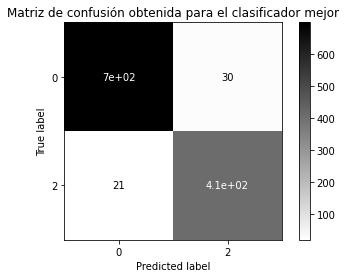

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       729
           2       0.93      0.95      0.94       433

    accuracy                           0.96      1162
   macro avg       0.95      0.96      0.95      1162
weighted avg       0.96      0.96      0.96      1162

La medida F1 para el clasificador GridSearchCV es 0.9417


In [95]:
print("Accuracy en test coon los nuevos datos de control: {:0.3f}%".format(
        100.0 * best_lr.score(x2_test, y2_test)))
y2_pred = best_lr.predict(x2_test)
acc = accuracy_score(y2_test,y2_pred)
print("El porcentaje de acierto obtenido es",acc*100)

metrics.plot_confusion_matrix(best_lr, x2_test, y2_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador mejor")
plt.show()

print(metrics.classification_report(y2_test,y2_pred))

f1 = metrics.f1_score(y2_test,y2_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(best_lr.__class__.__name__,f1))

### Árboles de decisión

In [96]:
dt2 = tree.DecisionTreeClassifier()
dt2.fit(x2_train, y2_train)

y2_pred = dt2.predict(x2_test)

acc_score = accuracy_score(y2_test, y2_pred)
print("Acierto de DT en la partición de test:", acc_score)

Acierto de DT en la partición de test: 0.9096385542168675


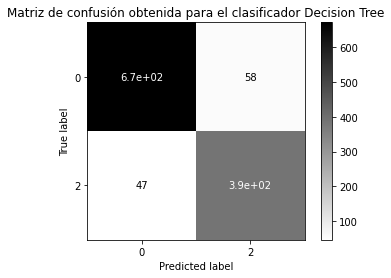

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       729
           2       0.87      0.89      0.88       433

    accuracy                           0.91      1162
   macro avg       0.90      0.91      0.90      1162
weighted avg       0.91      0.91      0.91      1162

La medida F1 para el clasificador DecisionTreeClassifier es 0.8803


In [97]:
metrics.plot_confusion_matrix(dt2, x2_test, y2_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Decision Tree")
plt.show()

print(metrics.classification_report(y2_test,y2_pred))

f1 = metrics.f1_score(y2_test,y2_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(dt.__class__.__name__,f1))

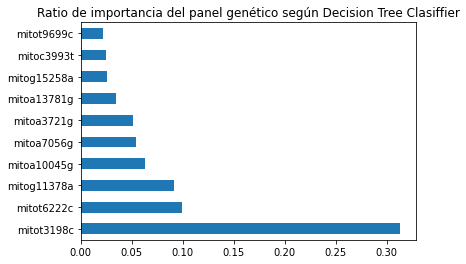

In [98]:
#En primer lugar, se capturan los valores del ranking de importancia
importancia = dt2.feature_importances_
#Se representan las 5 más importantes
(pd.Series(importancia, index=x_train.columns).nlargest(10).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Decision Tree Clasiffier")
plt.show()

### Gradient Boosting

In [99]:
from sklearn.ensemble import GradientBoostingClassifier
GBoost2 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.9,
                                 max_depth=2, random_state=0).fit(x2_train, y2_train)
GBoost2.score(x2_test, y2_test)

0.9810671256454389

El porcentaje de acierto obtenido es 98.10671256454388


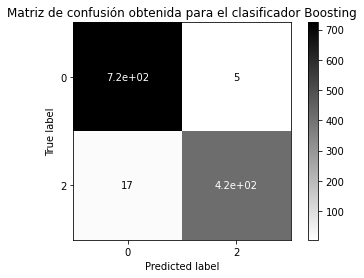

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       729
           2       0.99      0.96      0.97       433

    accuracy                           0.98      1162
   macro avg       0.98      0.98      0.98      1162
weighted avg       0.98      0.98      0.98      1162

La medida F1 para el clasificador GradientBoostingClassifier es 0.9742


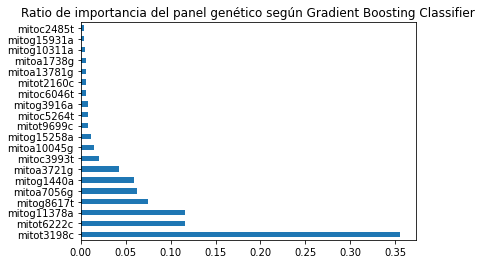

In [100]:
y2_pred = GBoost2.predict(x2_test)
acc = accuracy_score(y2_test,y2_pred)
print("El porcentaje de acierto obtenido es",acc*100)

metrics.plot_confusion_matrix(GBoost2, x2_test, y2_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Boosting")
plt.show()

print(metrics.classification_report(y2_test,y2_pred))

f1 = metrics.f1_score(y2_test,y2_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(GBoost2.__class__.__name__,f1))

#En primer lugar, se capturan los valores del ranking de importancia
importancia = GBoost2.feature_importances_
#Se representan las 5 más importantes
(pd.Series(importancia, index=x2_train.columns).nlargest(20).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Gradient Boosting Classifier")
plt.show()

# Diferencias entre ambos controles

In [101]:
def readControlData(path_control1, path_control2, path_names_col):
  #Transformamos la columna de affection status (que es 0 en ambos dataset) a
  # 0 si es del primer dataset
  # 1 si es del segundo dataset
  #Los nombres de las columnas son los mismos
  data1 = pd.read_csv(path_control1, sep=" ", header=None)
  names_col = pd.read_csv(path_names_col, sep=",", header=None)
  data2 = pd.read_csv(path_control2, sep=" ", header=None)

  names_c = names_col.to_numpy()[:,:].astype('U13')
  # En la columna 0 estan los nombres de los SNPs
  names_column = names_c[:,0]

  #Cambiamos a 1 el affection status del segundo dataset
  for i in range(0, data2.shape[0]):
    data2[5][i]='1'
  
  #Unimos datasets
  frames = [data1,data2]
  result = pd.concat(frames)

  #Repetimos los nombres de las columnas porque cada SNP son 2 columnas
  names_column = np.repeat(names_column,2)
  names_column = np.insert(names_column, 0, "Gender", axis=0)

  # Predecimos el affection status
  y = result.iloc[:,5]
  # Borramos la columna que queremos predecir
  result.drop(result.columns[5], axis=1, inplace=True)
  # Como nombre de las columnas vamos a establecer el ID del inivididuo
  names_row = result.iloc[:,1]
  # Borramos los ID
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[1], axis=1, inplace=True)

  x_df = pd.DataFrame(result.to_numpy()[:,:].astype('U13'),index=names_row, columns = names_column)
  y_df = y.values.flatten()

  if x_df.isnull().values.any():
    print("Hay datos perdidos")
  else:
    print("No hay datos perdidos")

  return x_df, y_df

In [102]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
x3, y3= readControlData('/content/drive/MyDrive/TFG/NBS/WTCCC2_NBSChrom26.iou','/content/drive/MyDrive/TFG/BC/WTCCC2_BCChrom26.iou',
                      '/content/drive/MyDrive/TFG/MS/WTCCC2_MS_Human670-QuadCustom_v1_APosSortedChrom26.cols')
x3_train, x3_test, y3_train, y3_test = train_test_split( x3, y3, test_size=0.25,random_state=1)
explorarBD(x3_train, x3_test, x3, y3 , y3_train, y3_test)
x3[5281:]

No hay datos perdidos
Número de instancias y número de variables: (5619, 273)
Valores de clase: [0 1]
Número de instancias para cada clase:  Counter({1: 2920, 0: 2699})
Número de instancias para cada clase test:  Counter({1: 731, 0: 674})
Número de instancias para cada clase train:  Counter({1: 2189, 0: 2025})
Numero de instancias en entrenamiento: 4214; y test: 1405


,Gender,mitoa10045g,mitoa10045g,mitoa10551g,mitoa10551g,mitoa11252g,mitoa11252g,mitoa11468g,mitoa11468g,mitoa12309g,mitoa12309g,mitoa13106g,mitoa13106g,mitoa13264g,mitoa13264g,mitoa13781g,mitoa13781g,mitoa14234g,mitoa14234g,mitoa14583g,mitoa14583g,mitoa15245g,mitoa15245g,mitoa15302g,mitoa15302g,mitoa15759g,mitoa15759g,mitoa15925g,mitoa15925g,mitoa16163g,mitoa16163g,mitoa16164g,mitoa16164g,mitoa1738g,mitoa1738g,mitoa3349g,mitoa3349g,mitoa3481g,mitoa3481g,mitoa3721g,...,mitot3198c,mitot3198c,mitot3395c,mitot3395c,mitot4337c,mitot4337c,mitot4562c,mitot4562c,mitot479c,mitot479c,mitot491c,mitot491c,mitot4978c,mitot4978c,mitot5005c,mitot5005c,mitot5443c,mitot5443c,mitot5496c,mitot5496c,mitot6153c,mitot6153c,mitot6222c,mitot6222c,mitot6681c,mitot6681c,mitot6777c,mitot6777c,mitot7176c,mitot7176c,mitot8278c,mitot8278c,mitot9699c,mitot9699c,mitot9717c,mitot9717c,mitot9900c,mitot9900c,mitot9951c,mitot9951c
1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
WTCCCT542527,1,16044,1555,19345,4167,18209,3739,22229,4788,17188,3927,7887,1746,20534,4195,9882,2419,11070,1732,9523,1191,11859,3238,10206,25932,22009,4316,15817,3684,17183,5994,16168,2648,11851,2031,20310,5652,14202,3006,21348,...,25273,4486,19825,5415,25571,6520,23519,7488,12825,2862,11779,1505,20171,5940,15468,4300,12076,2726,22426,3974,8907,3459,13960,4873,22914,4198,27963,4468,14420,2750,23574,10909,10745,3956,13514,4792,18948,4250,9611,1345
WTCCCT542637,1,22176,2485,22933,6431,23332,5444,30966,5537,22556,5209,12534,2482,28571,6195,14001,2703,14391,2329,17665,2339,18019,4381,12327,32336,33399,4915,22598,5871,24534,8320,23574,4311,19530,3627,26349,6935,20258,4189,28989,...,34720,5580,25128,6082,33865,8232,32434,9696,17264,3632,14923,1889,27504,7411,23657,5571,16361,3776,33189,6332,14863,5856,20237,6345,31530,5679,35639,4647,21163,3774,30627,13337,15031,5422,20865,6002,21584,5886,13813,2010
WTCCCT543520,2,22427,950,29588,3661,27128,3076,35333,3823,25750,3120,12359,1569,32646,3633,12413,1573,15530,1321,14489,1175,19358,3001,12338,30346,35209,3774,25801,3049,26298,5606,26254,2326,24903,2510,28940,4234,26667,2885,31103,...,38698,3307,32183,4249,39947,5405,36595,7288,17869,2075,13593,935,31459,4765,23389,3197,18146,1870,35705,4091,13710,3204,22898,4375,36796,4774,38389,2525,21655,2149,34636,9579,16909,3504,24035,4686,23597,3135,14299,1087
WTCCCT543533,2,24901,1605,6627,27669,30001,3224,1888,3569,6603,28788,9710,1633,33002,4273,13952,2256,15813,1604,17210,1604,19099,3719,15299,33800,33615,3797,3588,27730,27218,7143,25860,2705,23455,2619,32143,5535,4735,29509,32062,...,39865,3774,28159,4349,37974,6681,37742,8237,27745,3909,18995,1993,32819,5737,24099,4275,17074,2222,39080,4179,12496,3319,22253,5263,36781,4148,42280,3306,23395,2309,36092,10959,2073,19627,22283,4804,26950,3985,13728,1298
WTCCCT542530,1,20058,1787,25564,4606,24809,3763,3156,32166,5692,28760,10401,2087,27563,4640,13204,2519,12239,1889,12173,1601,17979,4026,11511,30639,29187,4126,23778,4665,20798,6716,20412,2856,14673,2006,27137,5806,18875,3450,30297,...,2634,35962,28970,4920,36128,6969,33603,8860,15962,2656,12814,1496,30245,6338,21551,4557,13959,2538,35050,4573,11755,4114,22228,5845,29255,4196,40097,3806,18839,2797,31020,12374,15456,4855,19695,5658,23034,4672,12463,1586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WTCCC66821,2,19934,1193,22818,3008,22412,3049,27070,4014,22188,3891,8253,1242,26233,3439,11636,1738,11575,1128,5355,576,16314,2975,11076,29921,28648,3587,21025,3126,20846,4597,20986,2297,18458,2135,26167,4331,18741,2374,26556,...,31119,3179,25692,3924,32466,5567,25366,6555,14740,1865,10803,1014,25415,4654,19584,3462,12569,1678,30921,3956,10085,3230,17439,3888,31538,4063,32999,3003,17443,2247,27545,10261,136

In [103]:
dt3 = tree.DecisionTreeClassifier()
dt3.fit(x3_train, y3_train)

y3_pred = dt3.predict(x3_test)

acc_score = accuracy_score(y3_test, y3_pred)
print("Acierto de DT en la partición de test:", acc_score)

Acierto de DT en la partición de test: 0.904626334519573


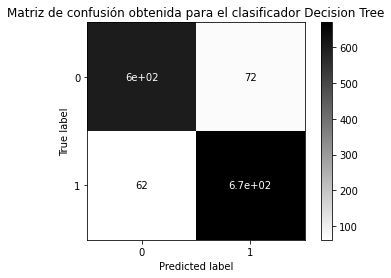

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       674
           1       0.90      0.92      0.91       731

    accuracy                           0.90      1405
   macro avg       0.90      0.90      0.90      1405
weighted avg       0.90      0.90      0.90      1405

La medida F1 para el clasificador DecisionTreeClassifier es 0.9090


In [104]:
metrics.plot_confusion_matrix(dt3, x3_test, y3_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Decision Tree")
plt.show()

print(metrics.classification_report(y3_test,y3_pred))

f1 = metrics.f1_score(y3_test,y3_pred,pos_label=1)
print("La medida F1 para el clasificador %s es %.4f"%(dt3.__class__.__name__,f1))

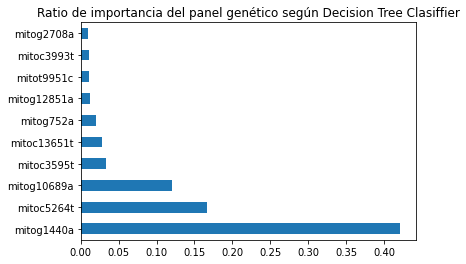

In [105]:
#En primer lugar, se capturan los valores del ranking de importancia
importancia = dt3.feature_importances_
#Se representan las 5 más importantes
(pd.Series(importancia, index=x_train.columns).nlargest(10).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Decision Tree Clasiffier")
plt.show()

In [106]:
clf3 = svm.SVC(C=100.0, break_ties=False, cache_size=200,
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
clf3.fit(x3_train,y3_train)

y3_pred = clf3.predict(x3_test)
acc = accuracy_score(y3_test,y3_pred)
print("Acierto SVM ",acc)

Acierto SVM  0.9537366548042705


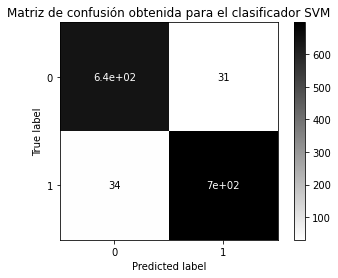

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       674
           1       0.96      0.95      0.96       731

    accuracy                           0.95      1405
   macro avg       0.95      0.95      0.95      1405
weighted avg       0.95      0.95      0.95      1405

La medida F1 para el clasificador SVC es 0.9519


In [107]:
metrics.plot_confusion_matrix(clf3, x3_test, y3_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador SVM")
plt.show()

print(metrics.classification_report(y3_test,y3_pred))

f1 = metrics.f1_score(y3_test,y3_pred,pos_label=0)
print("La medida F1 para el clasificador %s es %.4f"%(clf3.__class__.__name__,f1))

In [108]:
GBoost3 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.9,
                                 max_depth=2, random_state=0).fit(x3_train, y3_train)
GBoost3.score(x3_test, y3_test)

0.9722419928825623

El porcentaje de acierto obtenido es 97.22419928825623


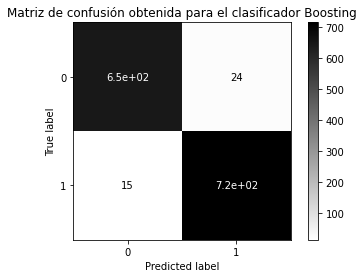

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       674
           1       0.97      0.98      0.97       731

    accuracy                           0.97      1405
   macro avg       0.97      0.97      0.97      1405
weighted avg       0.97      0.97      0.97      1405

La medida F1 para el clasificador GradientBoostingClassifier es 0.9735


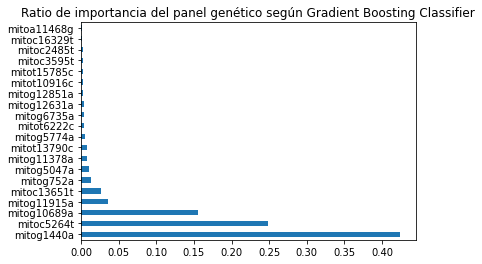

In [109]:
y3_pred = GBoost3.predict(x3_test)
acc = accuracy_score(y3_test,y3_pred)
print("El porcentaje de acierto obtenido es",acc*100)

metrics.plot_confusion_matrix(GBoost3, x3_test, y3_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Boosting")
plt.show()

print(metrics.classification_report(y3_test,y3_pred))

f1 = metrics.f1_score(y3_test,y3_pred,pos_label=1)
print("La medida F1 para el clasificador %s es %.4f"%(GBoost3.__class__.__name__,f1))

#En primer lugar, se capturan los valores del ranking de importancia
importancia = GBoost3.feature_importances_
#Se representan las 5 más importantes
(pd.Series(importancia, index=x3_train.columns).nlargest(20).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Gradient Boosting Classifier")
plt.show()

# Selección de Variables

In [110]:
"""
Lee las bases de datos y comprueba si hay datos perdidos:
    - path_data: indica la ruta del archivo con la base de datos
    - path_names: indica la ruta del archivo con los nombres de las columnas (SNPs)
    - path_control: ruta con los datos de control (individuos sanos)
    - path_col_control: ruta con los nombres de los SNPs de los datos de control
"""
import pandas as pd
import numpy as np
import collections as col
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

def readDataNoColumnsLabel(path_data, path_names, path_control, path_col_control):
  """ Leemos los datos
  --------------------------------------------------------------------------"""
  data = pd.read_csv(path_data, sep=" ", header=None)
  names_col = pd.read_csv(path_names, sep=",", header=None)
  control = pd.read_csv(path_control, sep=" ", header=None)
  names_ctrl = pd.read_csv(path_col_control, sep=",", header=None)

  """ Primero leo los nombres de los datos de las columnas de datos
  --------------------------------------------------------------------------"""
  # Tomamos los nombres de los snpis para nombrar las columnas
  names_c = names_col.to_numpy()[:,:].astype('U13')
  # En la columna 0 estan los nombres de los SNIPS
  names_column = names_c[:,0]

  """ Ahora buscamos las columnas en común entre los datos y los de control
  --------------------------------------------------------------------------"""
  names_ctrl_aux = names_ctrl.to_numpy()[:,:].astype('U13')
  names_control = names_ctrl_aux[:,0]
  delete = []
  for value in names_column:
    pos = np.where(names_control == value)
    if pos[0].size==0:
      delete.append(value)
  #Encontramos las dos posiciones a borrar que serán 4 en la base de datos
  borrar1 = np.where(names_column == delete[0])
  borrar2 = np.where(names_column == delete[1])
  names_column=np.delete(names_column, [borrar1[0][0],borrar2[0][0]])
  #Borramos las 4 posiciones desde la mas alta para que no afecte a las posiciones
  #más bajas a borrar
  #Se borra la posicion de la bd por 2 porque se repiten los SNPs, mas 7 por las 7
  #columnas iniciales y más 1 o 0 para borrar la pareja
  data.drop(data.columns[borrar2[0][0]*2+7+1], axis=1, inplace=True)
  data.drop(data.columns[borrar2[0][0]*2+7], axis=1, inplace=True)
  data.drop(data.columns[borrar1[0][0]*2+7+1], axis=1, inplace=True)
  data.drop(data.columns[borrar1[0][0]*2+7], axis=1, inplace=True)
  print("Posiciones borradas: ", delete)
  #Renombro las columnas para que el concat se haga bien
  data.columns=list(control.columns.values)
  """ Tratamos los nombres de los datos de las columnas con el formato correcto
  --------------------------------------------------------------------------"""
  names_column = np.repeat(names_column,2)
  names_column = np.insert(names_column, 0, "Gender", axis=0)

  """ Trato ahora con data
  --------------------------------------------------------------------------"""
  # Elimino los hijos de data
  row_elim=[]
  for i in range(0, data.shape[0]):
    if(data[2][i] != '0'):
      row_elim.append(i)
    else:
      data[5][i]='2'
  data=data.drop(row_elim)

  """ Junto con los datos de control
  --------------------------------------------------------------------------"""
  frames = [data,control]
  result = pd.concat(frames)
  """ Borro columnas de los datos
  --------------------------------------------------------------------------"""
  # Predecimos el affection status
  y = result.iloc[:,5]
  # Borramos la columna que queremos predecir
  result.drop(result.columns[5], axis=1, inplace=True)
  # Como nombre de las columnas vamos a establecer el ID del inivididuo
  names_row = result.iloc[:,1]
  # Borramos los ID
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[0], axis=1, inplace=True)
  result.drop(result.columns[1], axis=1, inplace=True)

  """ Establezco los nombres del dataframe
  --------------------------------------------------------------------------"""
  x_df = pd.DataFrame(result.to_numpy()[:,:].astype('U13'))
  y_df = y.values.flatten()

  """ Comprobamos que no haya datos perdidos
  --------------------------------------------------------------------------"""
  if x_df.isnull().values.any():
    print("Hay datos perdidos")
  else:
    print("No hay datos perdidos")

  return x_df, y_df, names_column, names_row


Posiciones borradas:  ['mitoc10874t', 'mitog10590a']
No hay datos perdidos


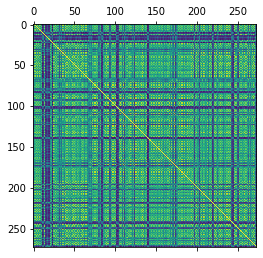

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272
0,1.000000,-0.026484,0.003610,-0.025286,0.004997,-0.023001,-0.004801,-0.013124,-0.014397,-0.017488,-0.008647,0.011499,-0.004082,-0.027534,-0.010987,0.016536,-0.005612,-0.013576,-0.000192,-0.011914,-0.011222,-0.029241,-0.020242,0.002505,-0.000434,-0.027366,-0.012590,-0.025960,-0.021914,-0.041775,-0.009880,-0.037541,-0.023655,-0.023041,-0.013014,-0.031952,-0.007896,-0.032135,0.003576,-0.027346,...,0.004203,-0.020449,-0.026705,-0.018844,-0.013769,0.007546,-0.019774,-0.004889,-0.018203,0.003094,0.005639,0.009158,-0.020377,-0.008569,-0.034836,-0.027818,-0.007399,0.001363,-0.007307,-0.010562,-0.025686,-0.002931,-0.037146,-0.009367,-0.013345,-0.004287,-0.015297,-0.008871,-0.046444,-0.015187,-0.025855,0.010043,-0.021278,-0.014174,-0.034025,-0.020314,-0.030829,-0.011661,-0.023824,0.002988
1,-0.026484,1.000000,-0.167946,0.675728,0.323621,0.650961,0.267312,0.633594,0.283287,0.554373,0.332890,-0.293993,-0.113909,0.692889,0.338232,-0.342353,-0.158040,0.110063,-0.164548,0.028255,-0.169692,0.707467,0.327437,-0.408713,0.345826,0.650757,0.305189,0.729637,0.314978,0.681347,0.313685,0.666319,-0.024801,0.719307,0.074510,0.702167,0.361011,0.701679,0.226339,0.672628,...,0.561498,0.214749,0.663273,0.268747,0.594081,0.314244,0.645394,0.292928,0.149853,-0.080362,-0.198542,-0.131246,0.683654,0.276337,0.775773,0.360433,0.181273,-0.088397,0.634714,0.329256,0.075219,0.333077,0.708242,0.244447,0.656421,0.365142,0.501793,0.288012,0.772373,0.071221,0.687914,0.095114,0.440882,0.307067,0.736385,0.289591,0.771411,0.298148,0.295925,-0.174169
2,0.003610,-0.167946,1.000000,-0.224865,-0.376446,-0.224979,-0.371008,-0.214358,-0.362729,-0.171839,-0.322736,0.126531,0.142209,-0.233820,-0.386907,0.123125,0.301394,0.056224,0.337381,0.115693,0.452901,-0.086130,-0.311650,0.118718,-0.348095,-0.214119,-0.396797,-0.187515,-0.361850,-0.143873,-0.346351,-0.115105,-0.008216,-0.152390,-0.124653,-0.212423,-0.367264,-0.174215,-0.268021,-0.221594,...,-0.205268,-0.317047,-0.216020,-0.408627,-0.227238,-0.352991,-0.208819,-0.399044,0.055024,0.057199,0.141311,0.318999,-0.203843,-0.397456,-0.169955,-0.399927,0.054103,0.056536,-0.219022,-0.376637,0.078948,-0.384991,-0.163645,-0.318144,-0.182307,-0.390053,-0.188994,-0.381108,-0.115323,-0.146460,-0.234517,-0.250903,-0.040407,-0.293193,-0.168353,-0.419798,-0.196118,-0.335469,0.035811,0.444815
3,-0.025286,0.675728,-0.224865,1.000000,0.395599,0.770875,0.323792,0.810907,0.340108,0.735044,0.339403,-0.336630,-0.230904,0.828171,0.395800,-0.274713,-0.275505,-0.039982,-0.257231,-0.106970,-0.230809,0.534018,0.343362,-0.390904,0.488642,0.798615,0.406580,0.726365,0.366262,0.596326,0.427278,0.536396,-0.140357,0.595228,-0.034150,0.833023,0.479983,0.805044,0.146970,0.825938,...,0.701480,0.266594,0.823050,0.398261,0.764423,0.457317,0.800753,0.429764,0.043607,-0.166253,-0.270792,-0.156507,0.830859,0.440529,0.748835,0.409043,0.022643,-0.223657,0.765722,0.358979,-0.064922,0.423754,0.655173,0.391233,0.798415,0.468703,0.644533,0.400045,0.656682,-0.049401,0.789243,0.211614,0.343466,0.267814,0.694197,0.431676,0.793517,0.254599,0.143708,-0.209237
4,0.004997,0.323621,-0.376446,0.395599,1.000000,0.443827,0.655045,0.420472,0.731183,0.242228,0.666925,-0.239760,-0.161856,0.434570,0.733226,-0.214779,-0.254171,-0.102867,-0.294694,-0.166147,-0.336287,0.216665,0.613077,-0.233946,0.679669,0.419354,0.741333,0.346399,0.641236,0.252994,0.648342,0.215143,0.021502,0.256526,0.192423,0.410525,0.770788,0.268974,0.473208,0.447339,...,0.419842,0.595274,0.444930,0.732875,0.418746,0.731249,0.452498,0.704303,-0.082555,-0.091758,-0.212457,-0.301081,0.434766,0.717555,0.351704,0.728066,-0.058908,-0.058780,0.440637,0.711637,-0.139904,0.703364,0.310209,0.494647,0.395135,0.749435,0.356952,0.738267,0.296574,0.203998,0.457932

In [111]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

#Releemos los datos
x, y, nc, nr = readDataNoColumnsLabel('/content/drive/MyDrive/TFG/Autism/AutismDuoChrom26.iou','/content/drive/MyDrive/TFG/Autism/Human1M-Duov3_B_PosSortedChrom26.cols','/content/drive/MyDrive/TFG/NBS/WTCCC2_NBSChrom26.iou',
               '/content/drive/MyDrive/TFG/MS/WTCCC2_MS_Human670-QuadCustom_v1_APosSortedChrom26.cols')
y=y.astype('float64')
le = LabelEncoder()
X_encoder=x.copy()

for i in X_encoder.columns:
  X_encoder[i] = le.fit_transform(X_encoder[[i]])
  X_encoder[i] = X_encoder[i].astype('float64')

corr_X = X_encoder.corr(method='pearson')
plt.matshow(corr_X)
plt.show()

X_encoder = pd.DataFrame(X_encoder.to_numpy(), index=nr, columns=nc)

corr_X


Veo algunas correlaciones bastante fuertes.

## Test Chi2

In [112]:
from sklearn.feature_selection import chi2

chi_scores =chi2(X_encoder, y)

p_values = pd.Series(chi_scores[1],index = X_encoder.columns)
p_values.sort_values(ascending = False , inplace = True)

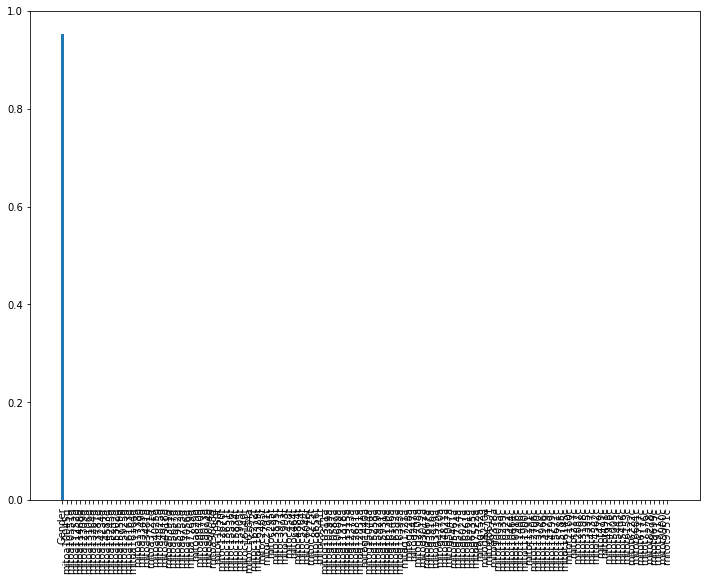

In [113]:
import matplotlib.pyplot as plt
#Grafica de los p-values
fig = plt.figure(figsize=(12, 9))
langs = X_encoder.columns
plt.bar(langs,p_values)
plt.xticks(rotation=90)
plt.show()

Hipótesis Nula: Son variables independientes.

Si tienen p-value > 0.05 se rechaza la hipótesis nula para esa variable

In [114]:
THRESHOLD_P_VALUE = 0.05

mayores=0
for i in p_values:
  if i > THRESHOLD_P_VALUE:
    mayores+=1

mayores

1

In [115]:
from sklearn.feature_selection import SelectKBest, chi2

select_k_best_classifier = SelectKBest(chi2, k=255)
X_values=select_k_best_classifier.fit_transform(X_encoder,y)

mask = select_k_best_classifier.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, X_encoder.columns):
    if bool:
        new_features.append(feature)

X_chi = pd.DataFrame(X_values, columns=new_features)

In [116]:
X_chi

,mitoa10045g,mitoa10045g,mitoa10551g,mitoa10551g,mitoa11252g,mitoa11252g,mitoa11468g,mitoa11468g,mitoa12309g,mitoa12309g,mitoa13106g,mitoa13106g,mitoa13264g,mitoa13264g,mitoa13781g,mitoa13781g,mitoa14234g,mitoa14234g,mitoa14583g,mitoa14583g,mitoa15245g,mitoa15245g,mitoa15302g,mitoa15302g,mitoa15759g,mitoa15759g,mitoa15925g,mitoa15925g,mitoa16163g,mitoa16163g,mitoa16164g,mitoa1738g,mitoa1738g,mitoa3349g,mitoa3349g,mitoa3481g,mitoa3721g,mitoa3721g,mitoa4025g,mitoa4025g,...,mitot217c,mitot217c,mitot2887c,mitot2887c,mitot3198c,mitot3198c,mitot3395c,mitot3395c,mitot4337c,mitot4337c,mitot4562c,mitot4562c,mitot479c,mitot491c,mitot491c,mitot4978c,mitot4978c,mitot5005c,mitot5443c,mitot5443c,mitot5496c,mitot5496c,mitot6153c,mitot6153c,mitot6222c,mitot6222c,mitot6681c,mitot6777c,mitot6777c,mitot7176c,mitot7176c,mitot8278c,mitot8278c,mitot9699c,mitot9699c,mitot9717c,mitot9900c,mitot9900c,mitot9951c,mitot9951c
0,1928.0,1721.0,2419.0,873.0,2406.0,967.0,2329.0,656.0,2422.0,1020.0,1482.0,763.0,2684.0,863.0,3541.0,250.0,1870.0,271.0,1880.0,92.0,1879.0,810.0,3520.0,1037.0,2658.0,1139.0,2671.0,1186.0,2788.0,1198.0,3127.0,2964.0,778.0,2262.0,739.0,944.0,2473.0,1470.0,2603.0,1089.0,...,2382.0,1013.0,2439.0,1300.0,2176.0,728.0,2471.0,994.0,2792.0,833.0,2026.0,1100.0,1275.0,1604.0,234.0,3808.0,350.0,1091.0,2161.0,429.0,1649.0,730.0,1336.0,1200.0,2924.0,1629.0,1088.0,2797.0,1321.0,2421.0,600.0,3258.0,1752.0,2684.0,1497.0,1338.0,2829.0,805.0,1510.0,483.0
1,1922.0,1643.0,1459.0,721.0,1123.0,287.0,1484.0,330.0,1950.0,847.0,386.0,119.0,1419.0,496.0,2626.0,8.0,631.0,1930.0,1051.0,1726.0,1843.0,556.0,3208.0,726.0,1962.0,484.0,1500.0,410.0,1514.0,850.0,1324.0,990.0,148.0,2110.0,995.0,439.0,1770.0,514.0,2151.0,762.0,...,2191.0,1328.0,1701.0,1168.0,1452.0,332.0,1951.0,502.0,1773.0,999.0,1689.0,543.0,1538.0,837.0,1844.0,3114.0,220.0,403.0,618.0,2044.0,1528.0,366.0,831.0,514.0,1697.0,665.0,764.0,2326.0,647.0,1736.0,189.0,2789.0,1243.0,1086.0,982.0,608.0,2220.0,487.0,58.0,272.0
2,2744.0,209.0,3162.0,1557.0,3255.0,1046.0,3203.0,1180.0,2908.0,2159.0,1637.0,1262.0,2830.0,789.0,1301.0,1822.0,2713.0,691.0,2512.0,573.0,2939.0,820.0,3530.0,1304.0,3131.0,1564.0,3744.0,1295.0,2442.0,835.0,2778.0,2525.0,691.0,3306.0,1273.0,1690.0,3147.0,968.0,3201.0,1415.0,...,2562.0,1342.0,2285.0,1170.0,2590.0,505.0,3399.0,1202.0,3435.0,1017.0,2422.0,716.0,939.0,3861.0,1767.0,2967.0,858.0,805.0,2340.0,634.0,3107.0,1003.0,2503.0,1146.0,3182.0,1820.0,1021.0,3274.0,857.0,3270.0,696.0,1536.0,1183.0,2990.0,1617.0,1369.0,2630.0,684.0,3029.0,229.0
3,1548.0,1587.0,2248.0,1051.0,1333.0,1044.0,2021.0,635.0,2361.0,928.0,1317.0,649.0,2873.0,754.0,2945.0,268.0,3112.0,851.0,2307.0,321.0,2454.0,719.0,3201.0,1123.0,2761.0,623.0,2902.0,623.0,2191.0,1045.0,2105.0,2998.0,688.0,2626.0,1031.0,714.0,2316.0,899.0,2551.0,887.0,...,2433.0,1215.0,1515.0,1027.0,2060.0,304.0,2533.0,713.0,2774.0,679.0,2700.0,1090.0,1833.0,882.0,1811.0,2518.0,877.0,780.0,869.0,79.0,2555.0,849.0,2413.0,1341.0,2184.0,2225.0,627.0,2529.0,744.0,2732.0,397.0,1540.0,1053.0,2786.0,1421.0,852.0,2609.0,709.0,2487.0,51.0
4,276.0,1163.0,217.0,215.0,553.0,152.0,486.0,103.0,210.0,152.0,2672.0,1657.0,373.0,256.0,1816.0,1361.0,3649.0,1610.0,3745.0,1256.0,276.0,148.0,2108.0,400.0,828.0,271.0,281.0,203.0,180.0,734.0,359.0,276.0,115.0,588.0,619.0,38.0,478.0,346.0,407.0,453.0,...,601.0,947.0,332.0,944.0,4142.0,2664.0,430.0,295.0,533.0,597.0,294.0,349.0,3810.0,3017.0,712.0,423.0,339.0,402.0,3603.0,1875.0,519.0,288.0,3444.0,375.0,293.0,1389.0,747.0,316.0,289.0,452.0,1936.0,268.0,909.0,17.0,441.0,204.0,301.0,90.0,3781.0,1028.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4422,3050.0,75.0,2530.0,1034.0,1782.0,600.0,2514.0,935.0,2288.0,1159.0,1411.0,264.0,2801.0,711.0,996.0,468.0

## Test de *Variance Threshold*

In [117]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_values=selector.fit_transform(X_chi)

mask = selector.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, X_chi.columns):
    if bool:
        new_features.append(feature)

X_var = pd.DataFrame(X_values, columns=new_features)

In [118]:
X_var

,mitoa10045g,mitoa10045g,mitoa10551g,mitoa10551g,mitoa11252g,mitoa11252g,mitoa11468g,mitoa11468g,mitoa12309g,mitoa12309g,mitoa13106g,mitoa13106g,mitoa13264g,mitoa13264g,mitoa13781g,mitoa13781g,mitoa14234g,mitoa14234g,mitoa14583g,mitoa14583g,mitoa15245g,mitoa15245g,mitoa15302g,mitoa15302g,mitoa15759g,mitoa15759g,mitoa15925g,mitoa15925g,mitoa16163g,mitoa16163g,mitoa16164g,mitoa1738g,mitoa1738g,mitoa3349g,mitoa3349g,mitoa3481g,mitoa3721g,mitoa3721g,mitoa4025g,mitoa4025g,...,mitot217c,mitot217c,mitot2887c,mitot2887c,mitot3198c,mitot3198c,mitot3395c,mitot3395c,mitot4337c,mitot4337c,mitot4562c,mitot4562c,mitot479c,mitot491c,mitot491c,mitot4978c,mitot4978c,mitot5005c,mitot5443c,mitot5443c,mitot5496c,mitot5496c,mitot6153c,mitot6153c,mitot6222c,mitot6222c,mitot6681c,mitot6777c,mitot6777c,mitot7176c,mitot7176c,mitot8278c,mitot8278c,mitot9699c,mitot9699c,mitot9717c,mitot9900c,mitot9900c,mitot9951c,mitot9951c
0,1928.0,1721.0,2419.0,873.0,2406.0,967.0,2329.0,656.0,2422.0,1020.0,1482.0,763.0,2684.0,863.0,3541.0,250.0,1870.0,271.0,1880.0,92.0,1879.0,810.0,3520.0,1037.0,2658.0,1139.0,2671.0,1186.0,2788.0,1198.0,3127.0,2964.0,778.0,2262.0,739.0,944.0,2473.0,1470.0,2603.0,1089.0,...,2382.0,1013.0,2439.0,1300.0,2176.0,728.0,2471.0,994.0,2792.0,833.0,2026.0,1100.0,1275.0,1604.0,234.0,3808.0,350.0,1091.0,2161.0,429.0,1649.0,730.0,1336.0,1200.0,2924.0,1629.0,1088.0,2797.0,1321.0,2421.0,600.0,3258.0,1752.0,2684.0,1497.0,1338.0,2829.0,805.0,1510.0,483.0
1,1922.0,1643.0,1459.0,721.0,1123.0,287.0,1484.0,330.0,1950.0,847.0,386.0,119.0,1419.0,496.0,2626.0,8.0,631.0,1930.0,1051.0,1726.0,1843.0,556.0,3208.0,726.0,1962.0,484.0,1500.0,410.0,1514.0,850.0,1324.0,990.0,148.0,2110.0,995.0,439.0,1770.0,514.0,2151.0,762.0,...,2191.0,1328.0,1701.0,1168.0,1452.0,332.0,1951.0,502.0,1773.0,999.0,1689.0,543.0,1538.0,837.0,1844.0,3114.0,220.0,403.0,618.0,2044.0,1528.0,366.0,831.0,514.0,1697.0,665.0,764.0,2326.0,647.0,1736.0,189.0,2789.0,1243.0,1086.0,982.0,608.0,2220.0,487.0,58.0,272.0
2,2744.0,209.0,3162.0,1557.0,3255.0,1046.0,3203.0,1180.0,2908.0,2159.0,1637.0,1262.0,2830.0,789.0,1301.0,1822.0,2713.0,691.0,2512.0,573.0,2939.0,820.0,3530.0,1304.0,3131.0,1564.0,3744.0,1295.0,2442.0,835.0,2778.0,2525.0,691.0,3306.0,1273.0,1690.0,3147.0,968.0,3201.0,1415.0,...,2562.0,1342.0,2285.0,1170.0,2590.0,505.0,3399.0,1202.0,3435.0,1017.0,2422.0,716.0,939.0,3861.0,1767.0,2967.0,858.0,805.0,2340.0,634.0,3107.0,1003.0,2503.0,1146.0,3182.0,1820.0,1021.0,3274.0,857.0,3270.0,696.0,1536.0,1183.0,2990.0,1617.0,1369.0,2630.0,684.0,3029.0,229.0
3,1548.0,1587.0,2248.0,1051.0,1333.0,1044.0,2021.0,635.0,2361.0,928.0,1317.0,649.0,2873.0,754.0,2945.0,268.0,3112.0,851.0,2307.0,321.0,2454.0,719.0,3201.0,1123.0,2761.0,623.0,2902.0,623.0,2191.0,1045.0,2105.0,2998.0,688.0,2626.0,1031.0,714.0,2316.0,899.0,2551.0,887.0,...,2433.0,1215.0,1515.0,1027.0,2060.0,304.0,2533.0,713.0,2774.0,679.0,2700.0,1090.0,1833.0,882.0,1811.0,2518.0,877.0,780.0,869.0,79.0,2555.0,849.0,2413.0,1341.0,2184.0,2225.0,627.0,2529.0,744.0,2732.0,397.0,1540.0,1053.0,2786.0,1421.0,852.0,2609.0,709.0,2487.0,51.0
4,276.0,1163.0,217.0,215.0,553.0,152.0,486.0,103.0,210.0,152.0,2672.0,1657.0,373.0,256.0,1816.0,1361.0,3649.0,1610.0,3745.0,1256.0,276.0,148.0,2108.0,400.0,828.0,271.0,281.0,203.0,180.0,734.0,359.0,276.0,115.0,588.0,619.0,38.0,478.0,346.0,407.0,453.0,...,601.0,947.0,332.0,944.0,4142.0,2664.0,430.0,295.0,533.0,597.0,294.0,349.0,3810.0,3017.0,712.0,423.0,339.0,402.0,3603.0,1875.0,519.0,288.0,3444.0,375.0,293.0,1389.0,747.0,316.0,289.0,452.0,1936.0,268.0,909.0,17.0,441.0,204.0,301.0,90.0,3781.0,1028.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4422,3050.0,75.0,2530.0,1034.0,1782.0,600.0,2514.0,935.0,2288.0,1159.0,1411.0,264.0,2801.0,711.0,996.0,468.0

## Selección basada en la norma L1

In [119]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_var, y)
model = SelectFromModel(lsvc, prefit=True)
X_svc = model.transform(X_var)

mask = model.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, X_var.columns):
    if bool:
        new_features.append(feature)

X_svc = pd.DataFrame(X_svc, columns=new_features)
X_svc

,mitoa10045g,mitoa10551g,mitoa10551g,mitoa11252g,mitoa11252g,mitoa11468g,mitoa11468g,mitoa12309g,mitoa12309g,mitoa13106g,mitoa13106g,mitoa13264g,mitoa13781g,mitoa13781g,mitoa14234g,mitoa14234g,mitoa14583g,mitoa14583g,mitoa15245g,mitoa15245g,mitoa15302g,mitoa15759g,mitoa15759g,mitoa15925g,mitoa15925g,mitoa16163g,mitoa16163g,mitoa16164g,mitoa1738g,mitoa1738g,mitoa3349g,mitoa3349g,mitoa3481g,mitoa3721g,mitoa3721g,mitoa4025g,mitoa4025g,mitoa4825g,mitoa4825g,mitoa4918g,...,mitot16145c,mitot16145c,mitot2160c,mitot2160c,mitot217c,mitot217c,mitot2887c,mitot2887c,mitot3198c,mitot3198c,mitot3395c,mitot3395c,mitot4337c,mitot4337c,mitot4562c,mitot4562c,mitot479c,mitot491c,mitot491c,mitot4978c,mitot4978c,mitot5005c,mitot5443c,mitot5443c,mitot5496c,mitot5496c,mitot6153c,mitot6222c,mitot6222c,mitot6681c,mitot6777c,mitot7176c,mitot8278c,mitot8278c,mitot9699c,mitot9717c,mitot9900c,mitot9900c,mitot9951c,mitot9951c
0,1721.0,2419.0,873.0,2406.0,967.0,2329.0,656.0,2422.0,1020.0,1482.0,763.0,863.0,3541.0,250.0,1870.0,271.0,1880.0,92.0,1879.0,810.0,1037.0,2658.0,1139.0,2671.0,1186.0,2788.0,1198.0,3127.0,2964.0,778.0,2262.0,739.0,944.0,2473.0,1470.0,2603.0,1089.0,389.0,50.0,2337.0,...,2740.0,1435.0,2395.0,962.0,2382.0,1013.0,2439.0,1300.0,2176.0,728.0,2471.0,994.0,2792.0,833.0,2026.0,1100.0,1275.0,1604.0,234.0,3808.0,350.0,1091.0,2161.0,429.0,1649.0,730.0,1200.0,2924.0,1629.0,1088.0,1321.0,600.0,3258.0,1752.0,2684.0,1338.0,2829.0,805.0,1510.0,483.0
1,1643.0,1459.0,721.0,1123.0,287.0,1484.0,330.0,1950.0,847.0,386.0,119.0,496.0,2626.0,8.0,631.0,1930.0,1051.0,1726.0,1843.0,556.0,726.0,1962.0,484.0,1500.0,410.0,1514.0,850.0,1324.0,990.0,148.0,2110.0,995.0,439.0,1770.0,514.0,2151.0,762.0,196.0,2665.0,1371.0,...,1574.0,572.0,2274.0,589.0,2191.0,1328.0,1701.0,1168.0,1452.0,332.0,1951.0,502.0,1773.0,999.0,1689.0,543.0,1538.0,837.0,1844.0,3114.0,220.0,403.0,618.0,2044.0,1528.0,366.0,514.0,1697.0,665.0,764.0,647.0,189.0,2789.0,1243.0,1086.0,608.0,2220.0,487.0,58.0,272.0
2,209.0,3162.0,1557.0,3255.0,1046.0,3203.0,1180.0,2908.0,2159.0,1637.0,1262.0,789.0,1301.0,1822.0,2713.0,691.0,2512.0,573.0,2939.0,820.0,1304.0,3131.0,1564.0,3744.0,1295.0,2442.0,835.0,2778.0,2525.0,691.0,3306.0,1273.0,1690.0,3147.0,968.0,3201.0,1415.0,3086.0,1021.0,3254.0,...,2590.0,914.0,3105.0,965.0,2562.0,1342.0,2285.0,1170.0,2590.0,505.0,3399.0,1202.0,3435.0,1017.0,2422.0,716.0,939.0,3861.0,1767.0,2967.0,858.0,805.0,2340.0,634.0,3107.0,1003.0,1146.0,3182.0,1820.0,1021.0,857.0,696.0,1536.0,1183.0,2990.0,1369.0,2630.0,684.0,3029.0,229.0
3,1587.0,2248.0,1051.0,1333.0,1044.0,2021.0,635.0,2361.0,928.0,1317.0,649.0,754.0,2945.0,268.0,3112.0,851.0,2307.0,321.0,2454.0,719.0,1123.0,2761.0,623.0,2902.0,623.0,2191.0,1045.0,2105.0,2998.0,688.0,2626.0,1031.0,714.0,2316.0,899.0,2551.0,887.0,3025.0,1004.0,3726.0,...,1686.0,416.0,2489.0,933.0,2433.0,1215.0,1515.0,1027.0,2060.0,304.0,2533.0,713.0,2774.0,679.0,2700.0,1090.0,1833.0,882.0,1811.0,2518.0,877.0,780.0,869.0,79.0,2555.0,849.0,1341.0,2184.0,2225.0,627.0,744.0,397.0,1540.0,1053.0,2786.0,852.0,2609.0,709.0,2487.0,51.0
4,1163.0,217.0,215.0,553.0,152.0,486.0,103.0,210.0,152.0,2672.0,1657.0,256.0,1816.0,1361.0,3649.0,1610.0,3745.0,1256.0,276.0,148.0,400.0,828.0,271.0,281.0,203.0,180.0,734.0,359.0,276.0,115.0,588.0,619.0,38.0,478.0,346.0,407.0,453.0,163.0,429.0,285.0,...,271.0,230.0,316.0,249.0,601.0,947.0,332.0,944.0,4142.0,2664.0,430.0,295.0,533.0,597.0,294.0,349.0,3810.0,3017.0,712.0,423.0,339.0,402.0,3603.0,1875.0,519.0,288.0,375.0,293.0,1389.0,747.0,289.0,1936.0,268.0,909.0,17.0,204.0,301.0,90.0,3781.0,1028.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4422,75.0,2530.0,1034.0,1782.0,600.0,2514.0,935.0,2288.0,1159.0,1411.0,264.0,711.0,996.0,468.0,1457.0,1939.0,985.0,1702.

## Selección basada en Árboles

In [120]:
from sklearn.ensemble import ExtraTreesClassifier
clf_sel = ExtraTreesClassifier(n_estimators=50)
clf_sel = clf_sel.fit(X_svc, y)
clf_sel.feature_importances_ 

array([0.00458559, 0.00190592, 0.00181908, 0.00276622, 0.00366633,
       0.00299921, 0.00551112, 0.00197608, 0.0020582 , 0.00448214,
       0.00195143, 0.00249017, 0.00218468, 0.00995758, 0.00291546,
       0.0023494 , 0.00519101, 0.00373955, 0.00324401, 0.00945678,
       0.00285319, 0.00330372, 0.00257751, 0.00220159, 0.00589686,
       0.00229248, 0.00195021, 0.00327693, 0.00268314, 0.00289704,
       0.00286869, 0.00176809, 0.00161968, 0.00280738, 0.02051952,
       0.00314264, 0.01300636, 0.00409847, 0.00254856, 0.00298947,
       0.00219306, 0.00216822, 0.00401406, 0.00302426, 0.00272344,
       0.00658302, 0.00196785, 0.00234017, 0.01163242, 0.00345825,
       0.00277151, 0.00523089, 0.00436797, 0.0030793 , 0.00318815,
       0.00399389, 0.00195481, 0.00231389, 0.00307435, 0.00728129,
       0.00418194, 0.00380264, 0.00421592, 0.0030124 , 0.00198811,
       0.00643471, 0.00534191, 0.00316249, 0.00676952, 0.00503888,
       0.00489096, 0.00288562, 0.00275037, 0.00209152, 0.00294

In [121]:
model = SelectFromModel(clf_sel, prefit=True)
X_etc = model.transform(X_svc)

mask = model.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, X_var.columns):
    if bool:
        new_features.append(feature)

X_etc = pd.DataFrame(X_etc, columns = new_features)
X_etc

,mitoa10045g,mitoa11468g,mitoa12309g,mitoa13264g,mitoa14234g,mitoa14583g,mitoa15759g,mitoa3349g,mitoa3721g,mitoa5391g,mitoa5952g,mitoa6753g,mitoa7056g,mitoa8870g,mitoc1050t,mitoc1050t,mitoc12670t,mitoc13651t,mitoc13651t,mitoc16149t,mitoc16329t,mitoc2791t,mitoc295t,mitoc3971t,mitoc3993t,mitoc3993t,mitoc458t,mitoc458t,mitoc464t,mitoc464t,mitoc5264t,mitoc5264t,mitoc7275t,mitoc8656t,mitoc9541t,mitog10311a,mitog10311a,mitog10587a,mitog10689a,mitog11378a,...,mitog15044a,mitog15258a,mitog15929a,mitog15931a,mitog16130a,mitog16146a,mitog16392a,mitog16393a,mitog1721a,mitog228a,mitog247a,mitog247a,mitog3012a,mitog3667a,mitog3916a,mitog3919a,mitog3919a,mitog4770a,mitog4770a,mitog4821a,mitog5047a,mitog5047a,mitog5461a,mitog5774a,mitog5774a,mitog6027a,mitog6261a,mitog7522a,mitog8270a,mitot10239c,mitot10464c,mitot11486c,mitot11900c,mitot1191c,mitot14179c,mitot14799c,mitot15671c,mitot217c,mitot2887c,mitot5443c
0,1721.0,656.0,1482.0,250.0,1880.0,810.0,1186.0,1470.0,1089.0,1160.0,1115.0,3961.0,608.0,957.0,891.0,4026.0,1836.0,876.0,1238.0,1032.0,1388.0,1196.0,1561.0,1078.0,1608.0,1510.0,798.0,1249.0,881.0,1625.0,1979.0,1291.0,1303.0,739.0,1735.0,2638.0,1307.0,1818.0,1007.0,1219.0,...,1682.0,1966.0,930.0,1165.0,1116.0,1103.0,1167.0,792.0,1860.0,901.0,1193.0,1088.0,1676.0,3736.0,1418.0,1099.0,1379.0,1246.0,1769.0,1199.0,1290.0,1019.0,1225.0,1313.0,125.0,1216.0,1249.0,2592.0,1496.0,1656.0,278.0,1108.0,1435.0,962.0,728.0,994.0,833.0,350.0,429.0,1510.0
1,1643.0,330.0,386.0,8.0,1051.0,556.0,410.0,514.0,762.0,473.0,461.0,3876.0,672.0,1980.0,781.0,4000.0,756.0,510.0,1087.0,1018.0,938.0,961.0,822.0,889.0,821.0,1130.0,597.0,1297.0,73.0,1242.0,823.0,925.0,701.0,403.0,976.0,2212.0,906.0,1322.0,1176.0,487.0,...,918.0,1471.0,1041.0,1057.0,634.0,903.0,716.0,803.0,1007.0,848.0,552.0,702.0,1623.0,3641.0,863.0,1060.0,1240.0,640.0,640.0,979.0,764.0,1197.0,1009.0,580.0,5.0,846.0,707.0,2399.0,1078.0,1023.0,1881.0,549.0,572.0,589.0,332.0,502.0,999.0,220.0,2044.0,58.0
2,209.0,1180.0,1637.0,1822.0,2512.0,820.0,1295.0,968.0,1415.0,994.0,1155.0,3037.0,1122.0,719.0,1483.0,1605.0,2377.0,235.0,998.0,1281.0,1400.0,1015.0,4128.0,2152.0,689.0,1522.0,1095.0,2255.0,390.0,1887.0,1413.0,1894.0,2158.0,504.0,1261.0,2887.0,1735.0,878.0,1888.0,849.0,...,1269.0,2226.0,3871.0,2745.0,531.0,989.0,3883.0,1157.0,1017.0,1073.0,933.0,1165.0,696.0,2056.0,912.0,1012.0,2285.0,1321.0,2236.0,1638.0,4009.0,2400.0,1754.0,1518.0,1288.0,834.0,1470.0,2733.0,117.0,1919.0,159.0,1272.0,914.0,965.0,505.0,1202.0,1017.0,858.0,634.0,3029.0
3,1587.0,635.0,1317.0,268.0,2307.0,719.0,623.0,899.0,887.0,1019.0,658.0,2044.0,767.0,534.0,1592.0,1874.0,1510.0,233.0,971.0,1145.0,1088.0,1071.0,1430.0,1040.0,727.0,1120.0,998.0,1549.0,154.0,1467.0,1429.0,2016.0,1187.0,296.0,1158.0,2307.0,1338.0,1098.0,1732.0,633.0,...,1417.0,1959.0,1183.0,1531.0,901.0,1791.0,1826.0,892.0,1139.0,1568.0,536.0,979.0,735.0,1694.0,752.0,898.0,1898.0,1431.0,1573.0,1244.0,1308.0,2551.0,1266.0,1071.0,1089.0,842.0,915.0,3672.0,2098.0,1506.0,249.0,770.0,416.0,933.0,304.0,713.0,679.0,877.0,79.0,2487.0
4,1163.0,103.0,2672.0,1361.0,3745.0,148.0,203.0,346.0,453.0,194.0,281.0,431.0,544.0,1787.0,372.0,585.0,624.0,68.0,788.0,704.0,33.0,182.0,735.0,583.0,71.0,445.0,14.0,581.0,1790.0,346.0,206.0,593.0,487.0,1710.0,507.0,781.0,753.0,297.0,818.0,265.0,...,580.0,2830.0,906.0,677.0,155.0,618.0,790.0,632.0,287.0,463.0,2296.0,447.0,2074.0,651.0,2579.0,314.0,492.0,574.0,142.0,462.0,552.0,1702.0,601.0,595.0,353.0,101.0,386.0,204.0,955.0,659.0,1505.0,299.0,230.0,249.0,2664.0,295.0,597.0,339.0,1875.0,3781.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4422,75.0,935.0,1411.0,468.0,985.0,658.0,336.0,431.0,1214.0,1020.0,1258.0,2481.0,506.0,397.0,958.0,606.0,1338.0,1664.0,287.0,849.0,942.0,1003

## Reentrenamiento de modelos con selección de variables

In [129]:
from sklearn.model_selection import train_test_split
x4_train, x4_test, y4_train, y4_test = train_test_split( X_svc, y, test_size=0.25,random_state=1)

### Árboles de decision

In [130]:
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

dt = tree.DecisionTreeClassifier()
dt.fit(x4_train, y4_train)

y_pred = dt.predict(x4_test)

acc_score = accuracy_score(y4_test, y_pred)
print("Acierto de DT en la partición de test:", acc_score)

Acierto de DT en la partición de test: 0.8536585365853658


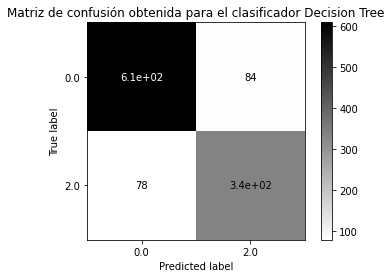

              precision    recall  f1-score   support

         0.0       0.89      0.88      0.88       694
         2.0       0.80      0.81      0.81       413

    accuracy                           0.85      1107
   macro avg       0.84      0.85      0.84      1107
weighted avg       0.85      0.85      0.85      1107

La medida F1 para el clasificador DecisionTreeClassifier es 0.8053


In [131]:
metrics.plot_confusion_matrix(dt, x4_test, y4_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Decision Tree")
plt.show()

print(metrics.classification_report(y4_test,y_pred))

f1 = metrics.f1_score(y4_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(dt.__class__.__name__,f1))

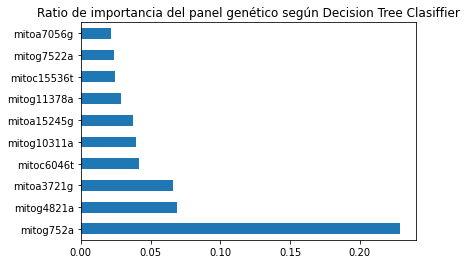

In [132]:
#En primer lugar, se capturan los valores del ranking de importancia
importancia = dt.feature_importances_
#Se representan las 5 más importantes
(pd.Series(importancia, index=x4_train.columns).nlargest(10).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Decision Tree Clasiffier")
plt.show()

### *Gradient Boosting*

In [133]:
from sklearn.ensemble import GradientBoostingClassifier
GBoost = GradientBoostingClassifier(n_estimators=200, learning_rate=0.9,
                                 max_depth=2, random_state=0).fit(x4_train, y4_train)
GBoost.score(x4_test, y4_test)

0.953026196928636

El porcentaje de acierto obtenido es 95.3026196928636


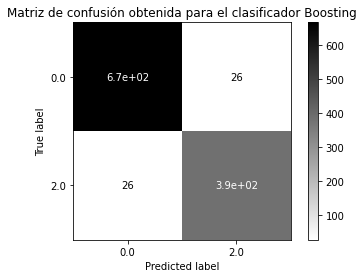

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       694
         2.0       0.94      0.94      0.94       413

    accuracy                           0.95      1107
   macro avg       0.95      0.95      0.95      1107
weighted avg       0.95      0.95      0.95      1107

La medida F1 para el clasificador GradientBoostingClassifier es 0.9370


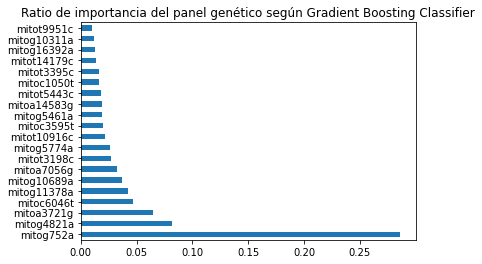

In [134]:
y_pred = GBoost.predict(x4_test)
acc = accuracy_score(y4_test,y_pred)
print("El porcentaje de acierto obtenido es",acc*100)

metrics.plot_confusion_matrix(GBoost, x4_test, y4_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador Boosting")
plt.show()

print(metrics.classification_report(y4_test,y_pred))

f1 = metrics.f1_score(y4_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(GBoost.__class__.__name__,f1))

#En primer lugar, se capturan los valores del ranking de importancia
importancia = GBoost.feature_importances_
#Se representan las 5 más importantes
(pd.Series(importancia, index=x4_train.columns).nlargest(20).plot(kind='barh'))
plt.title("Ratio de importancia del panel genético según Gradient Boosting Classifier")
plt.show()

Tanto *Árboles de Decisión* como *Gradient Boosting* lanzan resultados ligeramente peores con la selección de variables.

### *GridSearch CV*

In [135]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

params_grid=[
          {"lr":[LogisticRegression(penalty='l1',max_iter=500)],
                "lr__C":np.logspace(-2,2,5),
                "lr__solver":['lbfgs']},
          {"lr": [RandomForestClassifier(random_state = 1, n_jobs = -1, criterion = 'entropy')],
          "lr__n_estimators": [100, 250],
          "lr__max_depth": [9, 10]},
          {"lr": [SVC(class_weight='balanced', gamma='scale', degree=2)],
               "lr__C":np.logspace(-2,2,5),
               "lr__kernel": ['rbf', 'poly']}
            
]
best_lr=GridSearchCV(pipe,params_grid, scoring='accuracy', cv=5, n_jobs=-1)
best_lr.fit(x4_train,y4_train)
print("Parámetros del mejor clasificador:\n{}".format(best_lr.best_params_))
print("Accuracy en CV: {:0.3f}%".format(100.0 * best_lr.best_score_))
print("Accuracy en training: {:0.3f}%".format(
        100.0 * best_lr.score(x4_train, y4_train)))
print("Accuracy en test: {:0.3f}%".format(
        100.0 * best_lr.score(x4_test, y4_test)))

Parámetros del mejor clasificador:
{'lr': SVC(C=100.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False), 'lr__C': 100.0, 'lr__kernel': 'rbf'}
Accuracy en CV: 97.229%
Accuracy en training: 100.000%
Accuracy en test: 97.200%


Puntuación perfecta en el conjunto de entrenamiento y muy alta en test

El porcentaje de acierto obtenido es 97.1996386630533


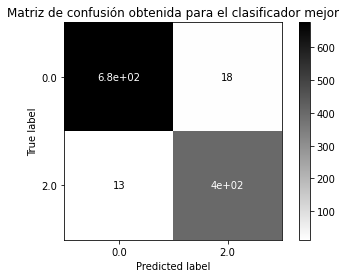

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       694
         2.0       0.96      0.97      0.96       413

    accuracy                           0.97      1107
   macro avg       0.97      0.97      0.97      1107
weighted avg       0.97      0.97      0.97      1107

La medida F1 para el clasificador GridSearchCV es 0.9627


In [138]:
y_pred = best_lr.predict(x4_test)
acc = accuracy_score(y4_test,y_pred)
print("El porcentaje de acierto obtenido es",acc*100)

metrics.plot_confusion_matrix(best_lr, x4_test, y4_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador mejor")
plt.show()

print(metrics.classification_report(y4_test,y_pred))

f1 = metrics.f1_score(y4_test,y_pred,pos_label=2)
print("La medida F1 para el clasificador %s es %.4f"%(best_lr.__class__.__name__,f1))

Este modelo (SVM) da mejor con selección de variables. 

El modelo con mejores resultados hasta ahora.

